# Libraries

In [3]:
import torch
import torch.nn  as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Model

In [4]:
class aMeijerNet(nn.Module):
  def __init__(self):
    super(aMeijerNet, self).__init__()
    # input layer - 288x288x3
    # convolution layer - kernel 5x5 depth 32 ELU activation
    self.conv = nn.Conv2d(3, 32, kernel_size = 5, padding=2)
    self.elu = nn.ELU()
    # pooling layer - kernel 2x2 stride 2x2
    self.pool = nn.MaxPool2d(kernel_size = 2, padding=1)

    # convolution layer 2 - kernel 5x5 depth 32 ELU activation
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu2 = nn.ELU()
    # pooling layer 2 - kernel 2x2 stride 2x2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # convulation layer 3 - kernel 5x5 depth 32 ELU activation
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu3 = nn.ELU()
    # pooling layer 3 - kernel 2x2 stride 2x2
    self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

    # dense layer
    self.fc1 = nn.Linear(36, 512) # 32, 36, 36 -> 32, 36, 512
    # ELU activation
    self.elu4 = nn.ELU()
    # 50% dropout
    self.do1 = nn.Dropout2d(p=0.5)

    # dense layer 32, 36, 512
    self.fc2 = nn.Linear(512, 512)

    # ELU activation
    self.elu5 = nn.ELU()

    # 50% dropout
    self.do2 = nn.Dropout2d(p=0.5)

    # dense layer 32, 36, 512
    self.fc3 = nn.Linear(512, 512)

    # ELU activation
    self.elu6 = nn.ELU()

    # 50% dropout
    self.do3 = nn.Dropout2d(p=0.5)

    # output layer - 3 outputs (defect, cracks, LRCs) - sigmoid and round for each output, binary step function, etc.
    self.out = nn.Linear(294912, 3)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
   # x = torch.transpose(x, 1, 0)
    c = self.conv(x)
    e = self.elu(c)
    p = self.pool(e)

    c2 = self.conv2(p)
    e2 = self.elu2(c2)
    p2 = self.pool2(e2)

    c3 = self.conv3(p2)
    e3 = self.elu3(c3)
    p3 = self.pool3(e3)

    fc1 = self.fc1(p3)
    e4 = self.elu4(fc1)
    do1 = self.do1(e4)

    fc2 = self.fc2(do1)
    e5 = self.elu5(fc2)
    do2 = self.do2(e5)

    fc3 = self.fc3(do2)
    e6 = self.elu6(fc3)
    do3 = self.do3(e6)

    out = self.sigm(self.out(torch.flatten(do3, start_dim=1, end_dim=-1)))
    outNum = torch.round(out, decimals=0)

    return outNum

# net = aMeijerNet()
# print(net(torch.from_numpy(imArr)))

# Dataset & Train/Validation

In [5]:
# load data
from PIL import Image
import numpy as np
import os
# rescale images to 288x288 (compression is better than expansion) - MAKE FUNCTION
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SewerDataset(Dataset):
    def __init__(self, datalocations, desiredW=288, desiredH=288):
        self.datalocations = datalocations
        self.channels, self.desiredW, self.desiredH = 3, desiredW, desiredH

    def getArray(self, file, plot=False):
        im = Image.open(f"{file}")
        if plot:
            im
        w, h = im.size
        rw, rh = (self.desiredW/w, self.desiredH/h)
        imRsz = im.resize((int(im.width * rw), int(im.height * rh)), resample=1)
        imArr = np.array(imRsz, dtype=np.float32).transpose((2, 0, 1)) # transpose inputs Cin, Hin, Win
        return imArr

    def __getitem__(self, index):
        self.arr = np.zeros((self.channels, self.desiredW, self.desiredH))
        if index == 0:
            self.arr = self.getArray(self.datalocations[index], True)
        else:
            self.arr = self.getArray(self.datalocations[index])
        label = np.array([int(self.datalocations[index][-7]),
                 int(self.datalocations[index][-6]),
                 int(self.datalocations[index][-5])])
        return self.arr, label

    def __len__(self):
        return len(self.datalocations)
    # 75% training, 15% for test, 10% validation

datalocation = "/content/drive/MyDrive/ENGG-680-ProjectDataDestination/"
pre = "/content/drive/MyDrive/ENGG-680-Project/"
files = list(set(os.listdir(datalocation)) - {'desktop.ini', 'whatever.ini'})
files = [datalocation+file for file in files]
saveFiles = f"{pre}model/saved/"

_, _, filesTrain, filesTest = train_test_split(files, files, test_size=0.25, random_state=42)
_, _, filesTest, filesVal = train_test_split(filesTest, filesTest, test_size=10/25, random_state=42)

trainSet = SewerDataset(filesTrain)
valSet = SewerDataset(filesVal)
criterion = torch.nn.CrossEntropyLoss()
trainLoader = DataLoader(dataset=trainSet, batch_size=64)
valLoader = DataLoader(dataset=valSet, batch_size=64)
learningRates = [.01, .05, .001, .005] + [.0001, .0005]  # last is 5
learningRates.sort()
print(learningRates)
trainErr = torch.zeros(len(learningRates))
valErr = torch.zeros(len(learningRates))
Models = {}
epochs = 20
learningRateLosses = []
# for i, lr in enumerate(learningRates):
# #     net = aMeijerNet()
# #     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# #     for epoch in range(epochs):
# #         for x, y in trainLoader:
# #             yHat = net(x)
# #             loss = criterion(yHat, y.to(torch.float32))
# #             print(f"Learning rate: {lr}; epoch: {epoch}; loss: {loss}.")
# #             optimizer.zero_grad()
# #             loss.backward()
# #             optimizer.step()
# #         torch.save(net, f"{saveFiles}net_{str(lr).replace('.', '_')}_{epoch}.pth")
# #     for x, y in trainLoader:
# #         # training data
# #         yhat = net(x)
# #         trainLoss = criterion (yhat, y.to(torch.float32))
# #         trainErr[i] = trainLoss.item()
#     net = torch.load(f"{saveFiles}net_{str(lr).replace('.', '_')}_{epochs-1}.pth")
#     print(f"{str(lr).replace('.', '_')} network loaded.")
#     losses=[]
#     with torch.no_grad():
#       for idx, (x, y) in enumerate(valLoader):
#           print(x.shape)
#           # validation data
#           yhat = net(x)
#           valLoss = criterion(yhat, y.to(torch.float32))
#           valErr[i] = valLoss.item()
#           losses.append(valLoss)
#           print(f"Loss {idx+1}: {valLoss}")
#       learningRateLosses.append(losses)
# #         Models.append(net)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]


In [ ]:
lrLossesArray = np.array(learningRateLosses)
lrLossesMean = np.mean(lrLossesArray, axis=1)
print(lrLossesArray.shape, lrLossesMean.shape)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#plt.semilogx(np.array(learning_rates), trainErr.numpy(), label="total training loss")
plt.semilogx(np.array(learningRates), lrLossesMean, label="total validation loss")
plt.ylabel("Total Loss")
plt.xlabel("Learning Rate")
plt.legend()
plt.show()

plt.plot(np.array(learningRates), lrLossesMean, label="total validation loss")
plt.ylabel("Total Loss")
plt.xlabel("Learning Rate")
plt.legend()
plt.show()

# we are looking for precision/recall given imbalanced dataset

# for net, lr in zip(Models, learningRates):
#     yhat = net(valSet.x)
#     plt.plot(valSet.x.numpy(), yhat.detach().numpy(), label=f"learning rate {str(lr)}")
# plt.plot(valSet.x.numpy(), valSet.func.numpy())

NameError: name 'lrLossesMean' is not defined

# Complete Training

In [ ]:
learningRate = .005
epochs=93
net = torch.load(f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
maxEpochs = 120
for epoch in range(epochs, maxEpochs):
    for x, y in trainLoader:
        x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        yHat = net(x)
        loss = criterion(yHat, y.to(torch.float32))
        print(f"Learning rate: {learningRate}; epoch: {epoch}; loss: {loss}.")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch>=60: torch.save(net, f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epoch}.pth")


<ipython-input-31-ab50bd31cb63>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epochs-1

Learning rate: 0.005; epoch: 60; loss: 1.3955045938491821.
Learning rate: 0.005; epoch: 60; loss: 1.0610322952270508.
Learning rate: 0.005; epoch: 60; loss: 0.9423879384994507.
Learning rate: 0.005; epoch: 60; loss: 1.1497668027877808.
Learning rate: 0.005; epoch: 60; loss: 1.0513274669647217.
Learning rate: 0.005; epoch: 60; loss: 0.9623256325721741.
Learning rate: 0.005; epoch: 60; loss: 1.1183831691741943.
Learning rate: 0.005; epoch: 60; loss: 0.9839801788330078.
Learning rate: 0.005; epoch: 60; loss: 0.6923373937606812.
Learning rate: 0.005; epoch: 60; loss: 1.1042972803115845.
Learning rate: 0.005; epoch: 60; loss: 0.9275993704795837.
Learning rate: 0.005; epoch: 60; loss: 1.398888111114502.
Learning rate: 0.005; epoch: 60; loss: 1.2903738021850586.
Learning rate: 0.005; epoch: 60; loss: 1.1313235759735107.
Learning rate: 0.005; epoch: 60; loss: 1.255908489227295.
Learning rate: 0.005; epoch: 60; loss: 1.4834437370300293.
Learning rate: 0.005; epoch: 60; loss: 0.8370417952537537.

In [15]:
trainErr = []

for i, (x, y) in enumerate(trainLoader):
    # training data
    x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32) #?
    yhat = net(x)
    trainLoss = criterion(yhat, y.to(torch.float32))
    trainErr.append(trainLoss.item())

Text(0.5, 1.0, 'Training Loss')

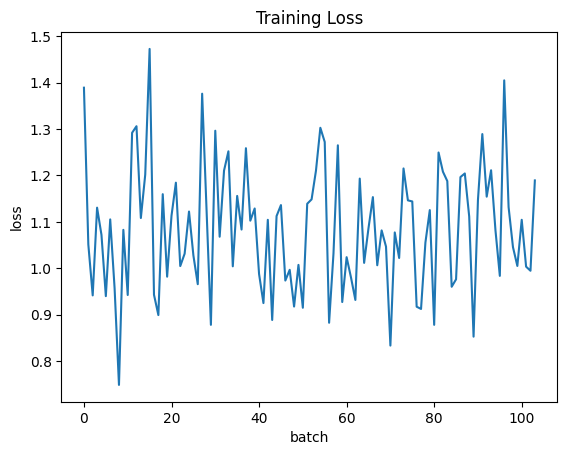

In [16]:
plt.plot(list(range(len(trainErr))), trainErr)
plt.xlabel("batch")
plt.ylabel("loss")
plt.title("Training Loss")

# Testing

In [10]:
testSet = SewerDataset(filesTest)
learningRate = .005
nTest = len(filesTest)
epochs=93
net = torch.load(f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth", map_location ="cpu")
predictionsCrack = np.zeros(nTest, )
predictionsLrc = np.zeros(nTest, )
predictionsDefect = np.zeros(nTest, )
actualCrack, actualLrc, actualDefect = np.zeros(nTest, ), np.zeros(nTest, ), np.zeros(nTest, )
testLoader = DataLoader(dataset=valSet, batch_size=1)
for i, (x, y) in enumerate(testLoader):
  #x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32) #?
  predictions = net(x)
  predictions = predictions.to("cpu").detach().numpy()
  predictions = predictions.reshape(-1,)
  predictionsCrack[i] = predictions[0]
  predictionsLrc[i] = predictions[1]
  predictionsDefect[i] = predictions[2]

  actualCrack[i] = y.to("cpu").detach().numpy().reshape(-1,)[0]
  actualLrc[i] = y.to("cpu").detach().numpy().reshape(-1,)[1]
  actualDefect[i] = y.to("cpu").detach().numpy().reshape(-1,)[2]

<ipython-input-10-0436b71f3cf0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epochs-1

In [11]:
print(f"For cracks: {classification_report(actualCrack, predictionsCrack)}\n{confusion_matrix(actualCrack, predictionsCrack)}.\n")
print(f"For LRC: {classification_report(actualLrc, predictionsLrc)}\n{confusion_matrix(actualLrc, predictionsLrc)}.\n")
print(f"For defect: {classification_report(actualDefect, predictionsDefect)}\n{confusion_matrix(actualDefect, predictionsDefect)}.")

For cracks:               precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      1119
         1.0       0.22      0.29      0.25       208

    accuracy                           0.73      1327
   macro avg       0.54      0.55      0.54      1327
weighted avg       0.76      0.73      0.74      1327

[[902 217]
 [147  61]].

For LRC:               precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1090
         1.0       0.27      0.26      0.26       237

    accuracy                           0.74      1327
   macro avg       0.55      0.55      0.55      1327
weighted avg       0.74      0.74      0.74      1327

[[920 170]
 [175  62]].

For defect:               precision    recall  f1-score   support

         0.0       0.76      0.73      0.74       883
         1.0       0.50      0.53      0.51       444

    accuracy                           0.66      1327
   macro avg       0.63      0.63      0.63  

# Data Analysis


In [ ]:
len(filesTrain), len(filesTest), len(filesVal)

(6635, 1327, 885)

In [ ]:
# fset = set(files)
# pre = "C:/Users/Daniel Polania/OneDrive - University of Calgary/ENGG-680-Project/data/"
# filenames = pd.read_excel(f"{pre}Combined excel.xlsx", usecols="A,B,C,D,R,U,V")
# filenames = filenames.set_index("Filename")
# import os

# for file in fset:
#     attrib = file.split("_")
#     name = attrib[0]+".png"
#     OSvalue = filenames.loc[name, "OS"]
#     newattrib = attrib[0] +"_"+ attrib[1] +"_"+ attrib[2][0] + str(OSvalue) + attrib[2][2:]
#     os.rename(f"{datalocation}{file}", f"{datalocation}{newattrib}")

# print("Done rename.")


In [ ]:
fileLabels = {}
for file in files:
    attrib = file.split("_")
    fileLabels[file] = {"va":attrib[1], "defectLabel":attrib[2][2], "crackLabel":attrib[2][0],  "lrcLabel":attrib[2][1]}
fileLabels

{'01114656_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '00338902_1_011.png': {'va': '1',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00943740_1_011.png': {'va': '1',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00919625_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00115220_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00733239_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00578364_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '01100287_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '01101260_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '00006053_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '01049629_0_011.png

In [ ]:
df = pd.DataFrame.from_dict(fileLabels, orient='index')
df.head()
df["defectLabel"] = df.defectLabel.astype(np.uint16)
df["crackLabel"] = df.crackLabel.astype(np.uint16)
df["lrcLabel"] = df.lrcLabel.astype(np.uint16)
df["va"] = df.lrcLabel.astype(np.float32)

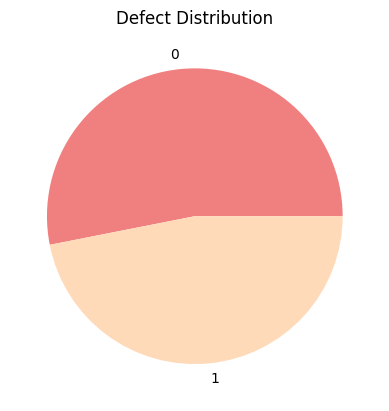

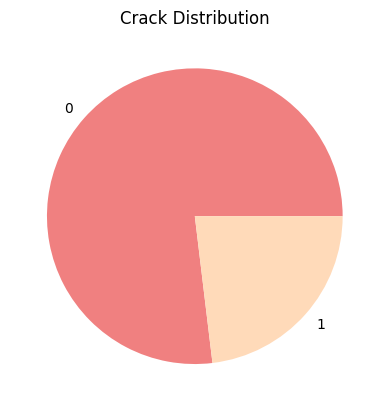

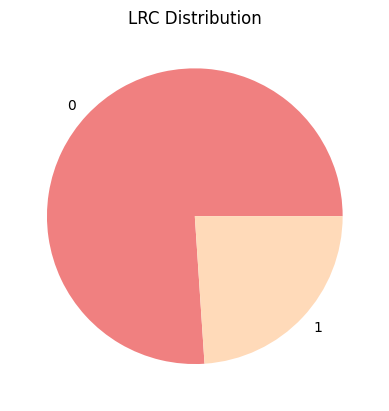

In [ ]:
describeDefects = df.defectLabel.value_counts()
describeDefects
plt.pie(describeDefects, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Defect Distribution")
plt.savefig(figuresPrefix+"defectDistribution.png")
plt.show()

describeCracks = df.crackLabel.value_counts()
describeCracks
plt.pie(describeCracks, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Crack Distribution")
plt.savefig(figuresPrefix+"crackDistribution.png")
plt.show()

describeLatcut = df.lrcLabel.value_counts()
describeLatcut
plt.pie(describeLatcut, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("LRC Distribution")
plt.savefig(figuresPrefix+"lrcDistribution.png")
plt.show()

In [ ]:
# set(list(df.defectLabel))
# imRsz
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

{0, 1}